## 掛接 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm,trange

## 載入資料

In [ ]:
# 確認壓縮檔路徑
filepath='/content/drive/MyDrive/20222電機系電腦視覺/HW3/'
os.listdir(filepath)

['cropped',
 'category.xlsx',
 'test_label.xlsx',
 'test_label.csv',
 'stanford_dogs.zip',
 '.ipynb_checkpoints',
 'stanfor_dogs']

In [ ]:
# # 解壓縮檔案
# !unzip '/content/drive/MyDrive/20222電機系電腦視覺/HW3/stanford_dogs.zip' -d '/content/drive/MyDrive/20222電機系電腦視覺/HW3/'

In [ ]:
dirpath='/content/drive/MyDrive/20222電機系電腦視覺/HW3/stanfor_dogs/'
os.listdir(dirpath) 

['test', 'train']

In [ ]:
imgSize=(100,100)
imgShape=(100,100,3)
batchSize=32

# train generator
trainDataGenerator = ImageDataGenerator(rescale = 1/255,
                      # augmentation
                      rotation_range = 40,
                      shear_range = 0.3,
                      zoom_range = 0.2,
                      validation_split=0.3)
valDataGenerator = ImageDataGenerator(rescale=1/255,validation_split=0.3)

trainBatch = trainDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='training'
)

valBatch = valDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='validation'
)

# test generator
testDataGenerator = ImageDataGenerator(rescale=1/255)

testBatch = testDataGenerator.flow_from_directory(
    dirpath,
    class_mode=None,
    batch_size=batchSize,
    target_size= imgSize,
    classes=['test']
)


Found 8400 images belonging to 120 classes.
Found 3600 images belonging to 120 classes.
Found 8580 images belonging to 1 classes.


## 載入模型

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape=imgShape,

)

x = base_model.output
x = layers.Dropout(0.5)(x)
x = layers.GlobalAveragePooling2D()(x)
output_layer = layers.Dense(units = 120, activation = 'softmax')(x)

# freeze the weight
base_model.trainable = False

model = tf.keras.Model(inputs = base_model.input, outputs = output_layer)

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0   

In [ ]:
# show the model stucture (截圖用)
model1 = tf.keras.Sequential([
    base_model,
    layers.Dropout(0.5),
    layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(120, activation="softmax")
])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 dropout_11 (Dropout)        (None, 3, 3, 512)         0         
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 120)               61560     
                                                                 
Total params: 14,776,248
Trainable params: 61,560
Non-trainable params: 14,714,688
_________________________________________________________________


## train model

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch=3
history = model.fit(
  trainBatch,
  steps_per_epoch = trainBatch.samples // batchSize,
  validation_data = valBatch,
  validation_steps = valBatch.samples // batchSize,
  epochs=epoch,
)

Epoch 1/3
168/168 [==============================] - 366s 2s/step - loss: 5.0777 - accuracy: 0.0314 - val_loss: 4.4309 - val_accuracy: 0.0636
Epoch 2/3
168/168 [==============================] - 329s 2s/step - loss: 4.6969 - accuracy: 0.0575 - val_loss: 4.3400 - val_accuracy: 0.0808
Epoch 3/3
168/168 [==============================] - 325s 2s/step - loss: 4.6031 - accuracy: 0.0702 - val_loss: 4.3318 - val_accuracy: 0.0775


## show the loss & accuracy curve

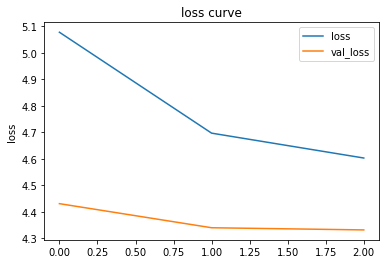

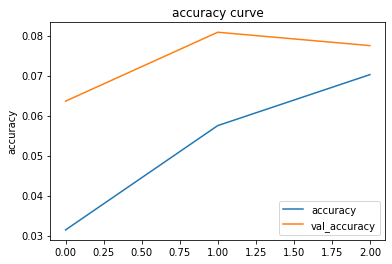

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## predict test data

In [ ]:
prediction = model.predict(testBatch)
prediction

array([[2.8739689e-04, 1.5436961e-04, 7.1557166e-05, ..., 3.6795065e-02,
        2.1290172e-02, 1.3958621e-03],
       [3.5542178e-03, 4.0162984e-05, 4.4491046e-04, ..., 1.2213198e-01,
        2.8983695e-02, 2.3568287e-03],
       [9.6836640e-03, 9.5173588e-04, 5.3258659e-03, ..., 1.5552072e-03,
        1.1008851e-03, 3.7172346e-03],
       ...,
       [3.7835170e-02, 5.9500313e-04, 4.0766387e-03, ..., 1.6199186e-02,
        3.2642947e-05, 8.9720434e-06],
       [3.1312048e-02, 1.7664307e-04, 2.0069325e-04, ..., 9.5370067e-03,
        1.9128680e-02, 5.1297783e-03],
       [7.5779128e-04, 8.7332702e-04, 1.4566754e-02, ..., 3.6391923e-03,
        9.0529007e-05, 4.6451166e-07]], dtype=float32)

## 輸出結果

In [ ]:
prediction_label=prediction.argmax(axis=1)
filename=testBatch.filenames
outputdf=pd.DataFrame()
outputdf['Name']=filename
outputdf['Label']=prediction_label
outputdf.to_csv('/content/drive/MyDrive/20222電機系電腦視覺/HW3/prediction.csv',index=False)

In [ ]:
import tensorflow as tf

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
(x_train1, y_train1), (x_test1, y_test1) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train1[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  